In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import io
import math
import tarfile
import multiprocessing

import scipy
import librosa
import boto3
from botocore import UNSIGNED
from botocore.config import Config
import requests
import matplotlib
import time
from IPython.display import Audio, display

import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T
'''
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
'''
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

"\nfor dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n"

In [2]:
df_en = pd.read_csv("/kaggle/input/common-voice/cv-valid-train.csv")
df_en.head()

,filename,text,up_votes,down_votes,age,gender,accent,duration
0,cv-valid-train/sample-000000.mp3,learn to recognize omens and follow them the o...,1,0,NaN,NaN,NaN,NaN
1,cv-valid-train/sample-000001.mp3,everything in the universe evolved he said,1,0,NaN,NaN,NaN,NaN
2,cv-valid-train/sample-000002.mp3,you came so that you could learn about your dr...,1,0,NaN,NaN,NaN,NaN
3,cv-valid-train/sample-000003.mp3,so now i fear nothing because it was those ome...,1,0,NaN,NaN,NaN,NaN
4,cv-valid-train/sample-000004.mp3,if you start your emails with greetings let me...,3,2,NaN,NaN,NaN,NaN


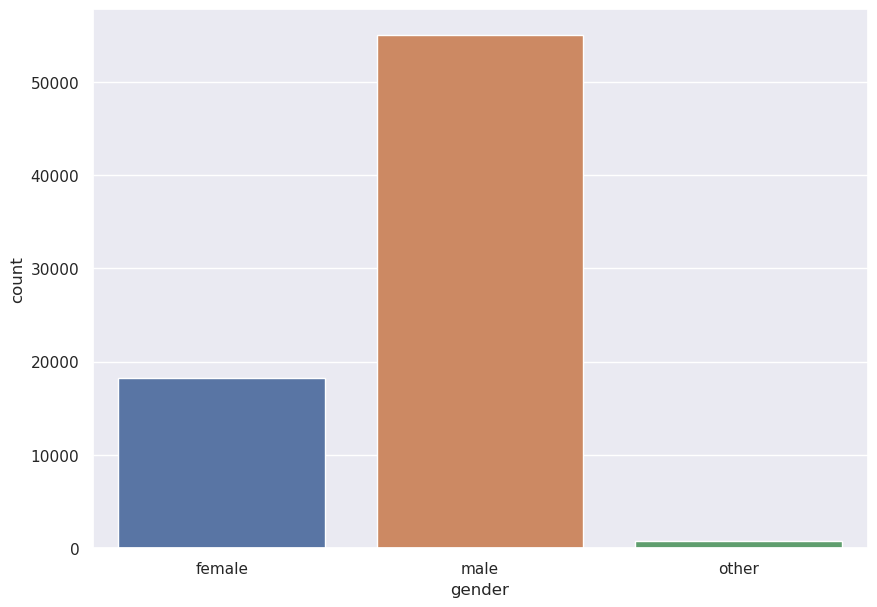

In [3]:
sns.set(rc={'figure.figsize':(10, 7)})
sns.countplot(x="gender", 
        data=df_en[df_en['gender'].notna()])

plt.show()

In [4]:
#Clean up datafram
def clean(df_en):
    df_en = df_en.dropna(subset = ['gender'])
    df_en = df_en.drop(labels=['up_votes', 'down_votes', 'age'], axis = 1)
    return df_en

df_en = clean(df_en)
df_en.head()

,filename,text,gender,accent,duration
5,cv-valid-train/sample-000005.mp3,a shepherd may like to travel but he should ne...,female,us,NaN
8,cv-valid-train/sample-000008.mp3,put jackie right on the staff,male,us,NaN
13,cv-valid-train/sample-000013.mp3,but he had found a guide and didn't want to mi...,female,us,NaN
14,cv-valid-train/sample-000014.mp3,as they began to decorate the hallway a silhou...,male,england,NaN
19,cv-valid-train/sample-000019.mp3,then they got ahold of some dough and went goofy,male,australia,NaN


In [5]:
#metadata = torchaudio.info("/kaggle/input/common-voice/cv-valid-train/cv-valid-train/sample-000005.mp3")
#print(metadata)

In [6]:
#-------------------------------------------------------------------------------
# Preparation of data and helper functions.
#-------------------------------------------------------------------------------

[width, height] = matplotlib.rcParams['figure.figsize']
if width < 10:
  matplotlib.rcParams['figure.figsize'] = [width * 2.5, height]


def _get_sample(path, resample=None):
  effects = [
    ["remix", "1"]
  ]
  if resample:
    effects.extend([
      ["lowpass", f"{resample // 2}"],
      ["rate", f'{resample}'],
    ])
  return torchaudio.sox_effects.apply_effects_file(path, effects=effects)

def print_stats(waveform, sample_rate=None, src=None):
  if src:
    print("-" * 10)
    print("Source:", src)
    print("-" * 10)
  if sample_rate:
    print("Sample Rate:", sample_rate)
  print("Shape:", tuple(waveform.shape))
  print("Dtype:", waveform.dtype)
  print(f" - Max:     {waveform.max().item():6.3f}")
  print(f" - Min:     {waveform.min().item():6.3f}")
  print(f" - Mean:    {waveform.mean().item():6.3f}")
  print(f" - Std Dev: {waveform.std().item():6.3f}")
  print()
  print(waveform)
  print()

def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].plot(time_axis, waveform[c], linewidth=1)
    axes[c].grid(True)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
    if ylim:
      axes[c].set_ylim(ylim)
  figure.suptitle(title)
  plt.show(block=False)

def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].specgram(waveform[c], Fs=sample_rate)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
  figure.suptitle(title)
  plt.show(block=False)

def play_audio(waveform, sample_rate):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  if num_channels == 1:
    display(Audio(waveform[0], rate=sample_rate))
  elif num_channels == 2:
    display(Audio((waveform[0], waveform[1]), rate=sample_rate))
  else:
    raise ValueError("Waveform with more than 2 channels are not supported.")

def inspect_file(path):
  print("-" * 10)
  print("Source:", path)
  print("-" * 10)
  print(f" - File size: {os.path.getsize(path)} bytes")
  print(f" - {torchaudio.info(path)}")

def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or 'Spectrogram (db)')
  axs.set_ylabel(ylabel)
  axs.set_xlabel('frame')
  im = axs.imshow(librosa.power_to_db(spec), origin='lower', aspect=aspect)
  if xmax:
    axs.set_xlim((0, xmax))
  fig.colorbar(im, ax=axs)
  plt.show(block=False)

def plot_mel_fbank(fbank, title=None):
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or 'Filter bank')
  axs.imshow(fbank, aspect='auto')
  axs.set_ylabel('frequency bin')
  axs.set_xlabel('mel bin')
  plt.show(block=False)

def get_spectrogram(
    n_fft = 400,
    win_len = None,
    hop_len = None,
    power = 2.0,
):
  waveform, _ = get_speech_sample()
  spectrogram = T.Spectrogram(
      n_fft=n_fft,
      win_length=win_len,
      hop_length=hop_len,
      center=True,
      pad_mode="reflect",
      power=power,
  )
  return spectrogram(waveform)

def plot_pitch(waveform, sample_rate, pitch):
  figure, axis = plt.subplots(1, 1)
  axis.set_title("Pitch Feature")
  axis.grid(True)

  end_time = waveform.shape[1] / sample_rate
  time_axis = torch.linspace(0, end_time,  waveform.shape[1])
  axis.plot(time_axis, waveform[0], linewidth=1, color='gray', alpha=0.3)

  axis2 = axis.twinx()
  time_axis = torch.linspace(0, end_time, pitch.shape[1])
  ln2 = axis2.plot(
      time_axis, pitch[0], linewidth=2, label='Pitch', color='green')

  axis2.legend(loc=0)
  plt.show(block=False)

def plot_kaldi_pitch(waveform, sample_rate, pitch, nfcc):
  figure, axis = plt.subplots(1, 1)
  axis.set_title("Kaldi Pitch Feature")
  axis.grid(True)

  end_time = waveform.shape[1] / sample_rate
  time_axis = torch.linspace(0, end_time,  waveform.shape[1])
  axis.plot(time_axis, waveform[0], linewidth=1, color='gray', alpha=0.3)

  time_axis = torch.linspace(0, end_time, pitch.shape[1])
  ln1 = axis.plot(time_axis, pitch[0], linewidth=2, label='Pitch', color='green')
  axis.set_ylim((-1.3, 1.3))

  axis2 = axis.twinx()
  time_axis = torch.linspace(0, end_time, nfcc.shape[1])
  ln2 = axis2.plot(
      time_axis, nfcc[0], linewidth=2, label='NFCC', color='blue', linestyle='--')

  lns = ln1 + ln2
  labels = [l.get_label() for l in lns]
  axis.legend(lns, labels, loc=0)
  plt.show(block=False)

DEFAULT_OFFSET = 201
SWEEP_MAX_SAMPLE_RATE = 48000
DEFAULT_LOWPASS_FILTER_WIDTH = 6
DEFAULT_ROLLOFF = 0.99
DEFAULT_RESAMPLING_METHOD = 'sinc_interpolation'

def _get_log_freq(sample_rate, max_sweep_rate, offset):
  """Get freqs evenly spaced out in log-scale, between [0, max_sweep_rate // 2]

  offset is used to avoid negative infinity `log(offset + x)`.

  """
  half = sample_rate // 2
  start, stop = math.log(offset), math.log(offset + max_sweep_rate // 2)
  return torch.exp(torch.linspace(start, stop, sample_rate, dtype=torch.double)) - offset

def _get_inverse_log_freq(freq, sample_rate, offset):
  """Find the time where the given frequency is given by _get_log_freq"""
  half = sample_rate // 2
  return sample_rate * (math.log(1 + freq / offset) / math.log(1 + half / offset))

def _get_freq_ticks(sample_rate, offset, f_max):
  # Given the original sample rate used for generating the sweep,
  # find the x-axis value where the log-scale major frequency values fall in
  time, freq = [], []
  for exp in range(2, 5):
    for v in range(1, 10):
      f = v * 10 ** exp
      if f < sample_rate // 2:
        t = _get_inverse_log_freq(f, sample_rate, offset) / sample_rate
        time.append(t)
        freq.append(f)
  t_max = _get_inverse_log_freq(f_max, sample_rate, offset) / sample_rate
  time.append(t_max)
  freq.append(f_max)
  return time, freq

def plot_sweep(waveform, sample_rate, title, max_sweep_rate=SWEEP_MAX_SAMPLE_RATE, offset=DEFAULT_OFFSET):
  x_ticks = [100, 500, 1000, 5000, 10000, 20000, max_sweep_rate // 2]
  y_ticks = [1000, 5000, 10000, 20000, sample_rate//2]

  time, freq = _get_freq_ticks(max_sweep_rate, offset, sample_rate // 2)
  freq_x = [f if f in x_ticks and f <= max_sweep_rate // 2 else None for f in freq]
  freq_y = [f for f in freq if f >= 1000 and f in y_ticks and f <= sample_rate // 2]

  figure, axis = plt.subplots(1, 1)
  axis.specgram(waveform[0].numpy(), Fs=sample_rate)
  plt.xticks(time, freq_x)
  plt.yticks(freq_y, freq_y)
  axis.set_xlabel('Original Signal Frequency (Hz, log scale)')
  axis.set_ylabel('Waveform Frequency (Hz)')
  axis.xaxis.grid(True, alpha=0.67)
  axis.yaxis.grid(True, alpha=0.67)
  figure.suptitle(f'{title} (sample rate: {sample_rate} Hz)')
  plt.show(block=True)



In [7]:
#Load mp3 audio file into waveform
waveform, sample_rate = torchaudio.load("/kaggle/input/common-voice/cv-valid-train/cv-valid-train/sample-000005.mp3")
#print(waveform[0])
'''
print_stats(waveform, sample_rate=sample_rate)
plot_waveform(waveform, sample_rate)
plot_specgram(waveform, sample_rate)
play_audio(waveform, sample_rate)
'''

'\nprint_stats(waveform, sample_rate=sample_rate)\nplot_waveform(waveform, sample_rate)\nplot_specgram(waveform, sample_rate)\nplay_audio(waveform, sample_rate)\n'

/opt/conda/lib/python3.7/site-packages/torchaudio/functional/functional.py:572: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (1025) may be set too low.
  "At least one mel filterbank has all zero values. "


tensor([[[-8.5888e+02, -8.5888e+02, -8.4684e+02,  ..., -8.1106e+02,
          -8.1701e+02, -8.5233e+02],
         [ 1.7366e-05,  1.7366e-05,  1.5781e+01,  ...,  5.5264e+01,
           5.0044e+01,  8.6731e+00],
         [-5.6962e-05, -5.6962e-05,  1.3683e+01,  ...,  3.2839e+01,
           3.0583e+01,  7.0158e+00],
         ...,
         [-1.5601e-04, -1.5601e-04,  1.9147e+00,  ...,  1.5152e+00,
           2.2540e+00,  8.6477e-01],
         [-1.7234e-03, -1.7234e-03,  1.2939e+00,  ...,  1.9431e+00,
           1.5790e+00,  6.0761e-01],
         [ 8.2343e-04,  8.2343e-04,  7.0755e-01,  ...,  3.8178e-01,
           8.2447e-01,  3.1618e-01]]])


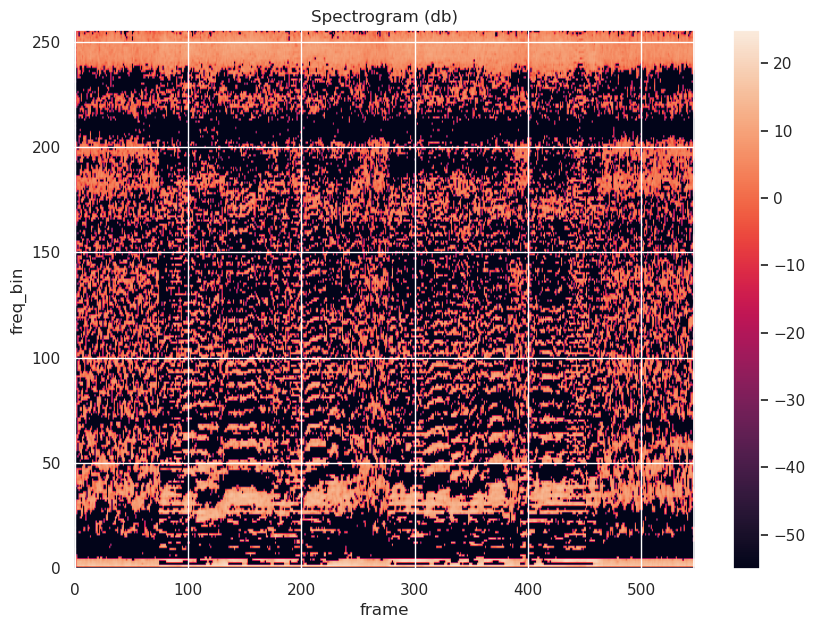

In [8]:
#Audio feature extraction

def to_mfcc(waveform, n_fft = 2048, win_length = None, hop_length = 512, n_mels = 256, n_mfcc = 256):
    mfcc_transform = T.MFCC(
        sample_rate=sample_rate,
        n_mfcc=n_mfcc,
        melkwargs={
            "n_fft": n_fft,
            "n_mels": n_mels,
            "hop_length": hop_length,
            "mel_scale": "htk",
        },
        )

    return mfcc_transform(waveform)

mfcc = to_mfcc(waveform)
print(mfcc)
plot_spectrogram(mfcc[0])

In [9]:
#Currently working on this portion (trying to find a way to optimize the functions in the next cell)
'''
train = pd.read_csv("/kaggle/input/common-voice/cv-valid-train.csv")
train = clean(train)
print(type(train))
def prepare_all_data(mp3_file_path):
    waveform, sample_rate = torchaudio.load(mp3_file_path)
    mfcc = to_mfcc(waveform) #Tensor
    return mfcc

mfcc = [prepare_all_data("/kaggle/input/common-voice/cv-valid-train/" + file) for file in train['filename']]
print(mfcc[:5])

# def to_column(csv):
#     chunksize = 1000
#     mfcc = []

#     for chunk in clean(pd.read_csv("/kaggle/input/common-voice/cv-valid-" + csv + ".csv", chunksize=chunksize)):
#         chunk_mfcc = chunk['filename'].apply(lambda x: prepare_all_data("/kaggle/input/common-voice/cv-valid-" + str(csv) + "/" + x))
#         mfcc.append(chunk_mfcc)

#     mfcc = pd.concat(mfcc)
#     csv['MFCC'] = mfcc 
#     return csv

# train = to_column(train)
# train.head()
'''

'\ntrain = pd.read_csv("/kaggle/input/common-voice/cv-valid-train.csv")\ntrain = clean(train)\nprint(type(train))\ndef prepare_all_data(mp3_file_path):\n    waveform, sample_rate = torchaudio.load(mp3_file_path)\n    mfcc = to_mfcc(waveform) #Tensor\n    return mfcc\n\nmfcc = [prepare_all_data("/kaggle/input/common-voice/cv-valid-train/" + file) for file in train[\'filename\']]\nprint(mfcc[:5])\n\n# def to_column(csv):\n#     chunksize = 1000\n#     mfcc = []\n\n#     for chunk in clean(pd.read_csv("/kaggle/input/common-voice/cv-valid-" + csv + ".csv", chunksize=chunksize)):\n#         chunk_mfcc = chunk[\'filename\'].apply(lambda x: prepare_all_data("/kaggle/input/common-voice/cv-valid-" + str(csv) + "/" + x))\n#         mfcc.append(chunk_mfcc)\n\n#     mfcc = pd.concat(mfcc)\n#     csv[\'MFCC\'] = mfcc \n#     return csv\n\n# train = to_column(train)\n# train.head()\n'

In [10]:
'''
#turn all data into MFCC spectograms
def prepare_all_data(mp3_file_path):
    waveform, sample_rate = torchaudio.load(mp3_file_path)
    mfcc = to_mfcc(waveform) #Tensor
    return mfcc

#Load datasests
train = pd.read_csv("/kaggle/input/common-voice/cv-valid-train.csv")
test = pd.read_csv("/kaggle/input/common-voice/cv-valid-test.csv")

#Clean datasets
train = clean(train)
test = clean(test)

#Turn each mp3 file for both datasets into corresponding MFCC tensor and save to new column in train and test
def to_column(csv):
    df = df['filename'].applymap(prepare_all_data)
    mfcc = []
    for file in csv['filename']:
        mfcc.append(prepare_all_data("/kaggle/input/common-voice/cv-valid-" + str(csv) + "/" + file))
    csv['MFCC'] = mfcc 
    return csv

train = to_column(train)
test = to_column(test)
print("yay")
'''

'\n#turn all data into MFCC spectograms\ndef prepare_all_data(mp3_file_path):\n    waveform, sample_rate = torchaudio.load(mp3_file_path)\n    mfcc = to_mfcc(waveform) #Tensor\n    return mfcc\n\n#Load datasests\ntrain = pd.read_csv("/kaggle/input/common-voice/cv-valid-train.csv")\ntest = pd.read_csv("/kaggle/input/common-voice/cv-valid-test.csv")\n\n#Clean datasets\ntrain = clean(train)\ntest = clean(test)\n\n#Turn each mp3 file for both datasets into corresponding MFCC tensor and save to new column in train and test\ndef to_column(csv):\n    df = df[\'filename\'].applymap(prepare_all_data)\n    mfcc = []\n    for file in csv[\'filename\']:\n        mfcc.append(prepare_all_data("/kaggle/input/common-voice/cv-valid-" + str(csv) + "/" + file))\n    csv[\'MFCC\'] = mfcc \n    return csv\n\ntrain = to_column(train)\ntest = to_column(test)\nprint("yay")\n'

In [11]:
#Create a Convolutional Neural Network

import torch.nn as nn
import torch.optim as optim

#Modify layers later to get better results
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

#Define loss function

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [12]:
#Train model

trainloader = []
for epoch in range(1):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Done!')

Done!


In [13]:
#Save trained model
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)